## Sirius/LNLS - Scientific Computing Group
## Planewave CDI

This notebook contains an example on how reconstruct a 3D synthetic planewave CDI dataset using sscCdi.

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import time
from sscCdi import planewave

from matplotlib.colors import LogNorm                                                                                                           
import matplotlib.gridspec as gridspec
from scipy.ndimage import gaussian_filter

import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter
from multiprocessing import Pool, cpu_count

### Some definitions

In [2]:
N = 256  #1710
N_sample = int((512/1500)*N)
fix =   N_sample %2 
zoom = (0.09*512)/N_sample

radius_sample = 0.31
shift_sample = 0.2
 
fix = 0 

## create observed data for the phase using the GCC phantom

found font


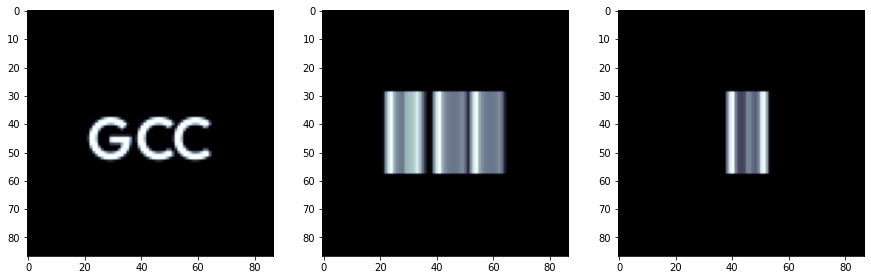

In [3]:
def create_2d_text_image(text, image_size, font_size=100):
    """Create a 2D image with the given text."""
    image = Image.new('L', image_size, 0)  # Create a black image
    draw = ImageDraw.Draw(image)
    
    # Try to use a truetype font
    try:
        font = ImageFont.truetype("OutfitSemiBold.ttf", font_size)
        print("found font")
    except IOError:
        # If truetype font is not available, use default
        font = ImageFont.load_default()
    
    # Calculate width and height of the text to center it
    text_width, text_height = draw.textsize(text, font=font)
    position = ((image_size[1] - text_width) // 2, (image_size[0] - text_height) // 2)
    
    draw.text(position, text, fill=255, font=font)  # Draw white text
    
    return np.array(image)

def create_3d_volume_from_2d(image_2d, depth=1):
    """Create a 3D volume from a 2D image by repeating the image along a new axis."""
    volume_3d = np.repeat(image_2d[np.newaxis,:, :], depth, axis=0)
    volume_3d[:image_2d.shape[0]//3,:,:] = 0
    volume_3d[int(2*image_2d.shape[0]/3)::,:,:] = 0
    return volume_3d

def insert_volume_into_larger_volume(small_volume, large_volume_shape):
    """Insert a smaller volume into a larger volume."""
    large_volume = np.zeros(large_volume_shape, dtype=np.uint8)
    z, y, x = small_volume.shape
    start_z = (large_volume_shape[0] - z) // 2
    start_y = (large_volume_shape[1] - y) // 2
    start_x = (large_volume_shape[2] - x) // 2
    
    large_volume[start_z:start_z+z, start_y:start_y+y, start_x:start_x+x] = small_volume
    return large_volume

# Create a 2D image with the text "GCC"
text_image = create_2d_text_image("GCC", image_size=(N_sample,N_sample), font_size=int(25*(N_sample/100)) )

# Create a 3D volume from the 2D image
phase_sample = create_3d_volume_from_2d(text_image, depth=text_image.shape[0])

phase_sample = (phase_sample-phase_sample.min())/(phase_sample.max()-phase_sample.min())*np.pi# -np.pi

# Insert the 3D text volume into a larger 3D volume
# final_volume = insert_volume_into_larger_volume(text_volume_3d, large_volume_shape=(N, N, N))

# Print shape of final volume to verify
# print(final_volume.shape)

# visu support 
fig, axs = plt.subplots(1,3, figsize=(15,7));
axs[0].imshow(phase_sample.sum(0),cmap='bone');
# axs[0].axis('off');

axs[1].imshow(phase_sample.sum(1),cmap='bone');
# axs[1].axis('off');

axs[2].imshow(phase_sample.sum(2),cmap='bone');
# axs[2].axis('off');

In [4]:
phase = np.zeros((N,N,N))
phase [(N-N_sample)//2:(N+N_sample)//2 - fix,
       (N-N_sample)//2:(N+N_sample)//2 - fix,
       (N-N_sample)//2:(N+N_sample)//2 - fix] = phase_sample

In [5]:
def create_rotation_matrix(angle, axis):
    """Create a rotation matrix for a given angle and axis."""
    angle = np.deg2rad(angle)
    c, s = np.cos(angle), np.sin(angle)
    if axis == 'x':
        return np.array([[1, 0, 0], [0, c, -s], [0, s, c]])
    elif axis == 'y':
        return np.array([[c, 0, s], [0, 1, 0], [-s, 0, c]])
    elif axis == 'z':
        return np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])

def rotate_coordinates(X, Y, Z, angle, axis):
    """Rotate the coordinates by a given angle around a specified axis."""
    rotation_matrix = create_rotation_matrix(angle, axis)
    coordinates = np.vstack((X.ravel(), Y.ravel(), Z.ravel()))
    rotated_coordinates = rotation_matrix @ coordinates
    X_rot, Y_rot, Z_rot = rotated_coordinates[0].reshape(X.shape), rotated_coordinates[1].reshape(Y.shape), rotated_coordinates[2].reshape(Z.shape)
    return X_rot, Y_rot, Z_rot

def create_bean(N):
    """Create a 3D array with a bean-shaped solid, rotated by a given angle."""
    radius = 0.31 * N  # 0.13 # 0.31 # 128:0.15
    shift = 0.2* N   # 0.09 # 0.21 # 128:0.10
    
    X, Y, Z = np.indices((N, N, N)) - N / 2

    # Rotate the coordinates
    X, Y, Z = rotate_coordinates(X, Y, Z, angle=30, axis='y')
    
    distance1 = np.sqrt((X-shift)**2 + Y**2 + Z**2)
    distance2 = np.sqrt((X+shift)**2 + Y**2 + Z**2)
    
    bean = (distance1 <= radius) | (distance2 <= radius)
    bean = gaussian_filter(bean.astype(float), sigma=N/30) > 0.9
    return bean

def create_random_prism(N):
    """Create a 3D array with a random prism."""
    size = np.random.randint(N // 30, N // 20, size=3)
    position = np.random.randint(N//3, 2*(N//3), size=3)
    prism = np.zeros((N, N, N), dtype=bool)
    prism[
        position[0]:position[0] + size[0],
        position[1]:position[1] + size[1],
        position[2]:position[2] + size[2]
    ] = True
    return prism

def create_known_prism(N,size,position):
    """Create a 3D array with a known prism."""
    prism = np.zeros((N, N, N), dtype=bool)
    prism[
        position[0]:position[0] + size[0],
        position[1]:position[1] + size[1],
        position[2]:position[2] + size[2]
    ] = True
    return prism

def create_prisms_in_parallel(args):
    """Helper function to create multiple prisms in parallel."""
    N, count, known_prisms = args
    prisms = np.zeros((N, N, N), dtype=bool)
    for idx in range(len(known_prisms)):
        size, position = known_prisms[idx]
        prism = create_known_prism(N,size,position)
        prisms[prism] = True
    return prisms

def add_geometrical_figures(volume, count, n_cores, known_prisms):
    """Add random zero-valued prisms to the given volume using parallel processing."""
    N = volume.shape[0]
    pool = Pool(processes=n_cores)
    counts = [count // n_cores] * n_cores
    results = pool.map(create_prisms_in_parallel, [(N, c, known_prisms) for c in counts])
    pool.close()
    pool.join() 
    for prisms in results:
        volume[prisms] = 0
    return volume

def create_volume_with_figures(N, n_cores, known_prisms):
    """Create a 3D volume with a central bean-shaped solid and zero-valued prisms inside it."""
    phantom = np.zeros((N, N, N), dtype=bool)
    bean = create_bean(N)
    phantom[bean] = 1  # Solid bean
    phantom = add_geometrical_figures(phantom, 1, n_cores, known_prisms)  # Add zero-valued prisms
    return phantom

# Parameters
n_cores = cpu_count()//5

V = 13
known_prisms = [[ [N_sample//V,N_sample//V,N_sample//V], [i*N_sample//V,i*N_sample//V,i*N_sample//V]  ] for i in range(V) ]
print(known_prisms)

# Generate the volume
phantom_sample = create_volume_with_figures(N_sample, n_cores,known_prisms)

# Optionally visualize the result
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.voxels(phantom, edgecolor='k')
# plt.show()

[[[6, 6, 6], [0, 0, 0]], [[6, 6, 6], [6, 6, 6]], [[6, 6, 6], [13, 13, 13]], [[6, 6, 6], [20, 20, 20]], [[6, 6, 6], [26, 26, 26]], [[6, 6, 6], [33, 33, 33]], [[6, 6, 6], [40, 40, 40]], [[6, 6, 6], [46, 46, 46]], [[6, 6, 6], [53, 53, 53]], [[6, 6, 6], [60, 60, 60]], [[6, 6, 6], [66, 66, 66]], [[6, 6, 6], [73, 73, 73]], [[6, 6, 6], [80, 80, 80]]]


In [6]:
phantom = np.zeros((N,N,N))
phantom[(N-N_sample)//2:(N+N_sample)//2,
        (N-N_sample)//2:(N+N_sample)//2,
        (N-N_sample)//2:(N+N_sample)//2] = phantom_sample

In [7]:
phantom = phantom*np.exp(1j*phase)

## View synthetic data

### Synthetic amplitude (Peanut)

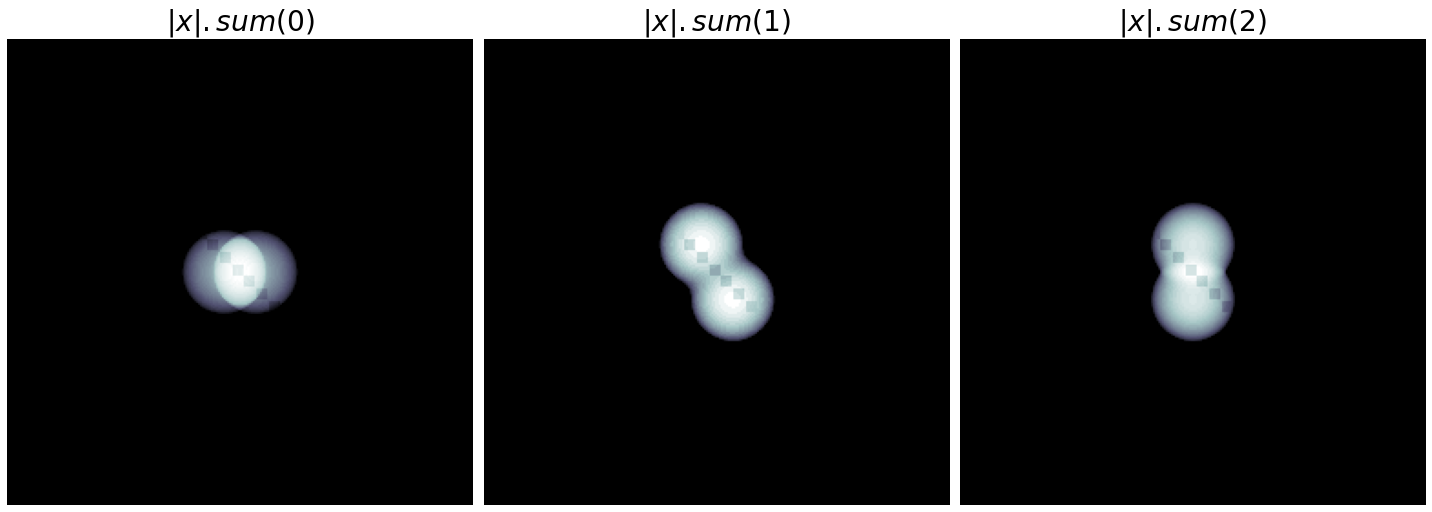

In [8]:
# Assuming out_ampli and N are defined
unpad = 0 # int(N // 4)

# Create a gridspec with 4 columns, the last column being for the color bar
fig = plt.figure(figsize=(20, 7))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1 ])  # Adjust width_ratios as needed

# Create the subplots
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
# cax = plt.subplot(gs[3])

# Plot the images
im0 = ax0.imshow(np.abs(phantom)[unpad:N-unpad, unpad:N-unpad, unpad:N-unpad].sum(0), cmap='bone')
ax0.axis('off')
ax0.set_title(r"$|x|.sum(0)$",fontsize = 28)
im1 = ax1.imshow(np.abs(phantom)[unpad:N-unpad, unpad:N-unpad, unpad:N-unpad].sum(1), cmap='bone')
ax1.axis('off')
ax1.set_title(r"$|x|.sum(1)$",fontsize = 28)
im2 = ax2.imshow(np.abs(phantom)[unpad:N-unpad, unpad:N-unpad, unpad:N-unpad].sum(2), cmap='bone')
ax2.axis('off')
ax2.set_title(r"$|x|.sum(2)$",fontsize = 28)

# Create the color bar in the dedicated space
# cbar = fig.colorbar(im0, cax=cax)
# cbar.ax.tick_params(labelsize=20)  # Adjust the fontsize as needed

# plt.savefig('peanuts/peanut_ampli_1368.png', dpi=300, bbox_inches='tight')  # Adjust filename and parameters as needed

plt.tight_layout()
plt.show()

### Synthetic phase (GCC)

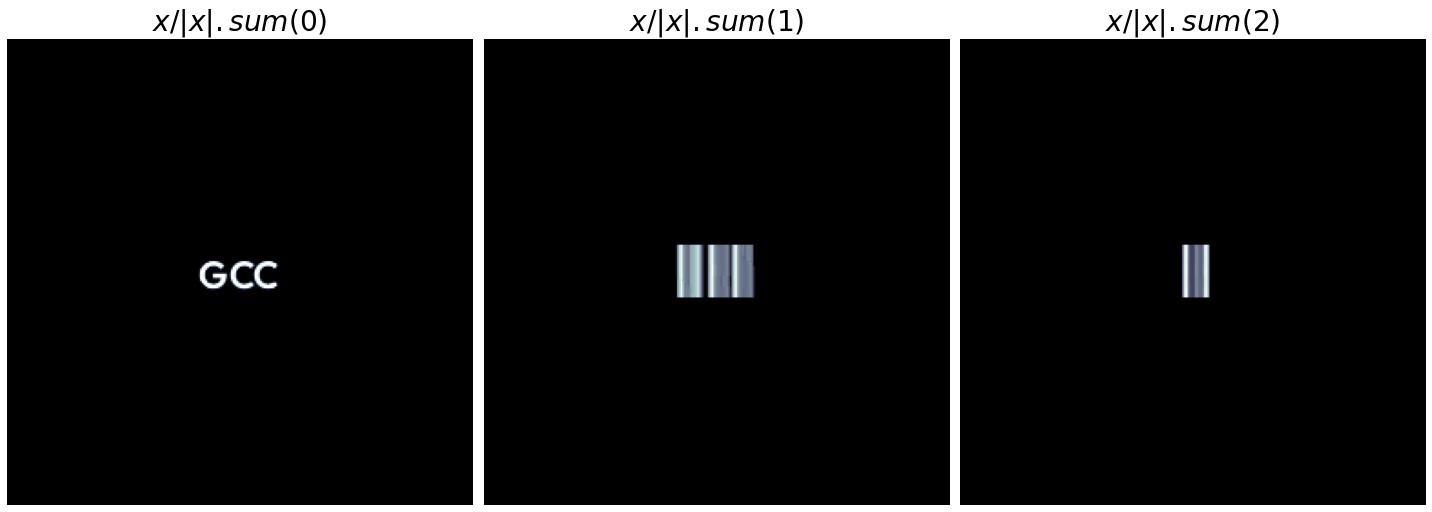

In [9]:
# Assuming out_ampli and N are defined
unpad = 0 # int(N // 4)

# Create a gridspec with 4 columns, the last column being for the color bar
fig = plt.figure(figsize=(20, 7))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1 ])  # Adjust width_ratios as needed

# Create the subplots
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
# cax = plt.subplot(gs[3])

# Plot the images
im0 = ax0.imshow(np.angle(phantom)[unpad:N-unpad, unpad:N-unpad, unpad:N-unpad].sum(0), cmap='bone')
ax0.axis('off')
ax0.set_title(r"$x/|x|.sum(0)$",fontsize = 28)
im1 = ax1.imshow(np.angle(phantom)[unpad:N-unpad, unpad:N-unpad, unpad:N-unpad].sum(1), cmap='bone')
ax1.axis('off')
ax1.set_title(r"$x/|x|.sum(1)$",fontsize = 28)
im2 = ax2.imshow(np.angle(phantom)[unpad:N-unpad, unpad:N-unpad, unpad:N-unpad].sum(2), cmap='bone')
ax2.axis('off')
ax2.set_title(r"$x/|x|.sum(2)$",fontsize = 28)

# Create the color bar in the dedicated space
# cbar = fig.colorbar(im0, cax=cax)
# cbar.ax.tick_params(labelsize=20)  # Adjust the fontsize as needed

# plt.savefig('peanuts/peanut_phase_1368.png', dpi=300, bbox_inches='tight')  # Adjust filename and parameters as needed

plt.tight_layout()
plt.show()

### Create observed data using the forward model

In [10]:
data = (np.abs(np.fft.fftn(phantom)).real)

### View observed data

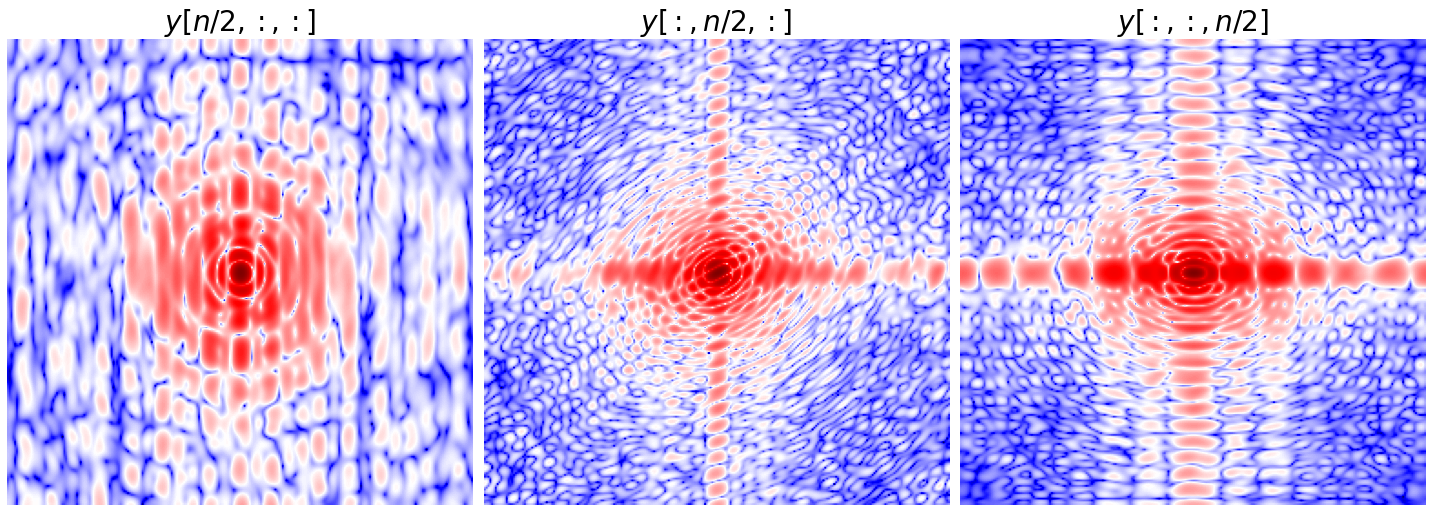

In [11]:
# Assuming out_ampli and N are defined
unpad = 0 # int(N // 4)
shift_data = np.fft.fftshift(data)

# Create a gridspec with 4 columns, the last column being for the color bar
fig = plt.figure(figsize=(20, 7))
gs = gridspec.GridSpec(1,3, width_ratios=[1, 1, 1])  # Adjust width_ratios as needed

# Create the subplots
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
# cax = plt.subplot(gs[3])

# Plot the images
im0 = ax0.imshow(np.log(np.abs(shift_data)[N//2, unpad:N-unpad, unpad:N-unpad]+1e-5), cmap='seismic')
ax0.axis('off')
ax0.set_title(r"$y[n/2,:,:]$",fontsize = 28)
im1 = ax1.imshow(np.log(np.abs(shift_data)[unpad:N-unpad, N//2, unpad:N-unpad]+1e-5), cmap='seismic')
ax1.axis('off')
ax1.set_title(r"$y[:,n/2,:]$",fontsize = 28)
im2 = ax2.imshow(np.log(np.abs(shift_data)[unpad:N-unpad, unpad:N-unpad, N//2]+1e-5), cmap='seismic')
ax2.axis('off')
ax2.set_title(r"$y[:,:,n/2]$",fontsize = 28)

# Create the color bar in the dedicated space
# cbar = fig.colorbar(im0, cax=cax)
# cbar.ax.tick_params(labelsize=20)  # Adjust the fontsize as needed

#plt.savefig('peanuts/peanut_data_'+str(N)+'.png', dpi=300, bbox_inches='tight')  # Adjust filename and parameters as needed

plt.tight_layout()
plt.show()

### Subsample data, if needed

(256, 256, 256)


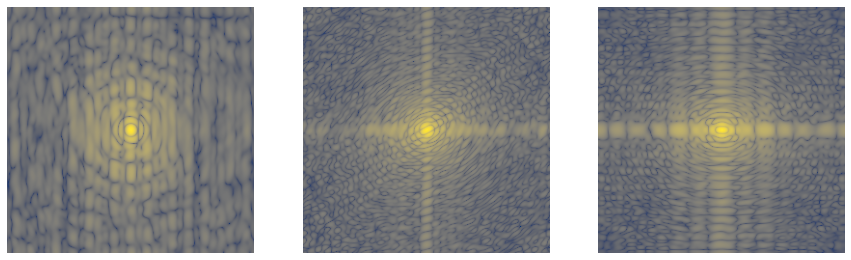

In [12]:
# subsample data to size (M,M,M) instead of (N,N,N)
# if M=N, no subsample is done
M = 256 
offset = (N-M)//2
data_sub = np.fft.fftshift(data)[offset:N-offset,offset:N-offset,offset:N-offset].copy()
print(data_sub.shape)

# visualize 
fig, axs = plt.subplots(1,3, figsize=(15,7));
axs[0].imshow(data_sub[M//2,:,:],cmap='cividis',norm=LogNorm());
axs[0].axis('off');
axs[1].imshow(data_sub[:,M//2,:],cmap='cividis',norm=LogNorm());
axs[1].axis('off');
axs[2].imshow(data_sub[:,:,M//2],cmap='cividis',norm=LogNorm());
axs[2].axis('off');


# fftshift the data 
data_sub = np.fft.fftshift(data_sub)

## Initial guesses

In [13]:
initial_ampli = np.fft.fftshift(np.abs(np.fft.ifftn(data_sub)))
initial_phase = np.random.uniform(0,1,size = (M,M,M))
initial_obj = initial_ampli*np.exp(1j*initial_phase)
initial_sup = np.zeros((M,M,M))
initial_sup[M//4:int(3*(M//4)),M//4:int(3*(M//4)),M//4:int(3*(M//4))] = np.ones((M//2,M//2,M//2))

In [14]:
print("initial_obj.dtype = ", initial_obj.dtype)
print("initial_obj.shape = ", initial_obj.shape)
print("initial_phase.shape = ", initial_phase.shape)

initial_obj.dtype =  complex128
initial_obj.shape =  (256, 256, 256)
initial_phase.shape =  (256, 256, 256)


### View initial guesses

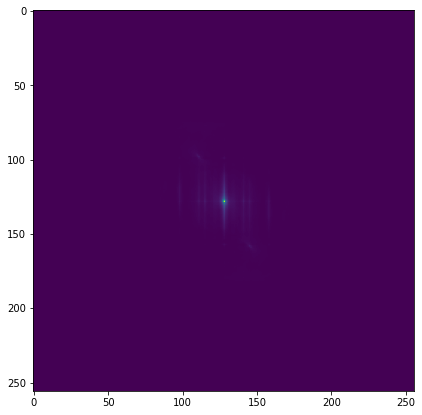

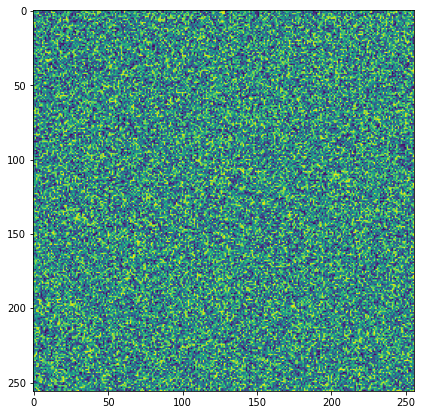

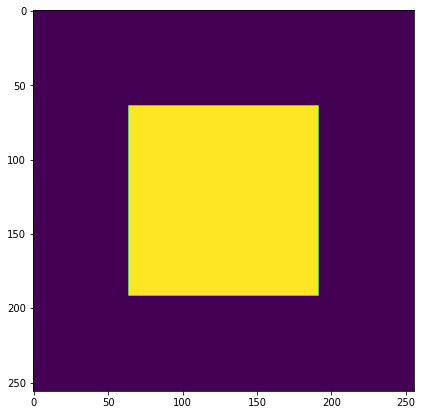

In [15]:
plt.figure(figsize=(7,7))
plt.imshow(np.abs(initial_obj)[:,128,:]);

plt.figure(figsize=(7,7))
plt.imshow(np.angle(initial_obj)[:,128,:]);

plt.figure(figsize=(7,7))
plt.imshow(initial_sup[:,128,:]);

## Run! 

In [80]:
# params
dic = {}  
dic['gpus'] = [0,1] # [0,1,2,3,4,5] 

# optimization parameters. Making these True will increase GPU memory usage and decrease execution time 
dic["swap_d_x"] = False
dic["map_d_signal"] = False
dic["map_d_support"] = False

# debug parameter 
dic['timing'] = True


# methods 
dic['method'] = {0:{"name": "HIO",
                    "niter": 20000,                        
                    "shrinkwrap_subiter": 20,
                    "initial_shrinkwrap_subiter": 0,
                    "beta": 0.99,
                    "beta_update": 7,
                    "beta_reset_subiter": -1,
                    "sigma": 6.0/np.pi,
                    "sigma_mult": 0.99,
                    "shrinkwrap_threshold": 11.0,
                    "shrinkwrap_iter_filter": "amplitude", 
                    "extra_constraint": None,               
                    "extra_constraint_subiter": 1,
                    "initial_extra_constraint_subiter": 0},
                1:{"name": "ER",
                   "niter": 200}}


 
# support parameters  
sup_data =  initial_sup
dic['support'] = { 'p': 10, 'r': 0.5, 'data':sup_data} 

# initial object data 
dic['obj_input'] = initial_obj


tic = time.time()
out_obj, out_finsup = planewave.pwcdi3d(data_sub, dic)
toc = time.time() - tic

print('Elapsed time for HIO3D: {} sec'.format(toc))

ssc-cdi: Memory available at selected GPUs [ before allocation ]
ssc-cdi: Memory available at selected GPUs [ after allocation ]


128 ms
ssc-cdi: Iteration 185 takes 1.274432 ms ** 
ssc-cdi: m_projection_M() time: 1.187584 ms
ssc-cdi: m_projection_S_only(): 0.112768 ms
ssc-cdi: Iteration 186 takes 1.300352 ms ** 
ssc-cdi: m_projection_M() time: 1.177024 ms
ssc-cdi: m_projection_S_only(): 0.112736 ms
ssc-cdi: Iteration 187 takes 1.289760 ms ** 
ssc-cdi: m_projection_M() time: 1.178176 ms
ssc-cdi: m_projection_S_only(): 0.112480 ms
ssc-cdi: Iteration 188 takes 1.290656 ms ** 
ssc-cdi: m_projection_M() time: 1.187584 ms
ssc-cdi: m_projection_S_only(): 0.112512 ms
ssc-cdi: Iteration 189 takes 1.300096 ms ** 
ssc-cdi: m_projection_M() time: 1.175520 ms
ssc-cdi: m_projection_S_only(): 0.112768 ms
ssc-cdi: Iteration 190 takes 1.288288 ms ** 
ssc-cdi: m_projection_M() time: 1.172640 ms
ssc-cdi: m_projection_S_only(): 0.112768 ms
ssc-cdi: Iteration 191 takes 1.285408 ms ** 
ssc-cdi: m_projection_M() time: 1.177760 ms
ssc-cdi: m_projection_S_only(): 0.112896 ms
ssc-cdi: Iteration 192 takes 1.290656 ms ** 
ssc-cdi: m_projec

## View results

#### Recovered Amplitude

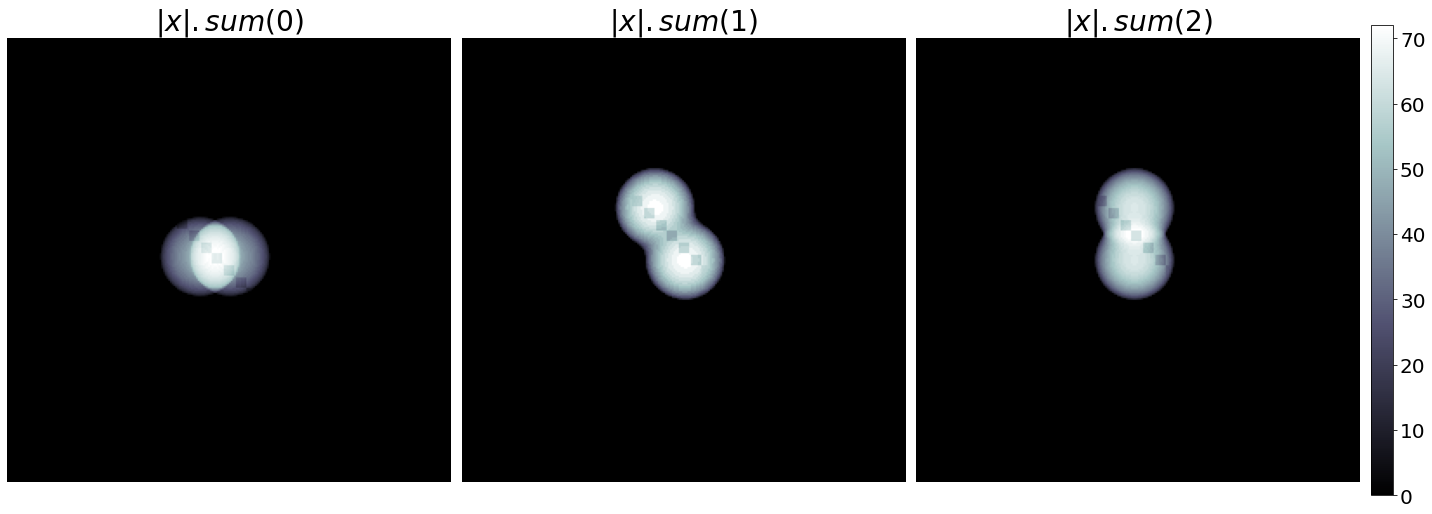

In [81]:
# Assuming out_ampli and N are defined
unpad = 0 # int(N // 4)

out_ampli = np.abs(out_obj)

# Create a gridspec with 4 columns, the last column being for the color bar
fig = plt.figure(figsize=(20, 7))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05])  # Adjust width_ratios as needed

# Create the subplots
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
cax = plt.subplot(gs[3])

# Plot the images
im0 = ax0.imshow(out_ampli[unpad:M-unpad, unpad:M-unpad, unpad:M-unpad].sum(0), cmap='bone')
ax0.axis('off')
ax0.set_title(r"$|x|.sum(0)$",fontsize = 28)
im1 = ax1.imshow(out_ampli[unpad:M-unpad, unpad:M-unpad, unpad:M-unpad].sum(1), cmap='bone')
ax1.axis('off')
ax1.set_title(r"$|x|.sum(1)$",fontsize = 28)
im2 = ax2.imshow(out_ampli[unpad:M-unpad, unpad:M-unpad, unpad:M-unpad].sum(2), cmap='bone')
ax2.axis('off')
ax2.set_title(r"$|x|.sum(2)$",fontsize = 28)

# Create the color bar in the dedicated space
cbar = fig.colorbar(im0, cax=cax)
cbar.ax.tick_params(labelsize=20)  # Adjust the fontsize as needed

# plt.savefig('peanuts/peanut_recon_ampli_1024.png', dpi=300, bbox_inches='tight')  # Adjust filename and parameters as needed

plt.tight_layout()
plt.show()

#### Recovered Phase

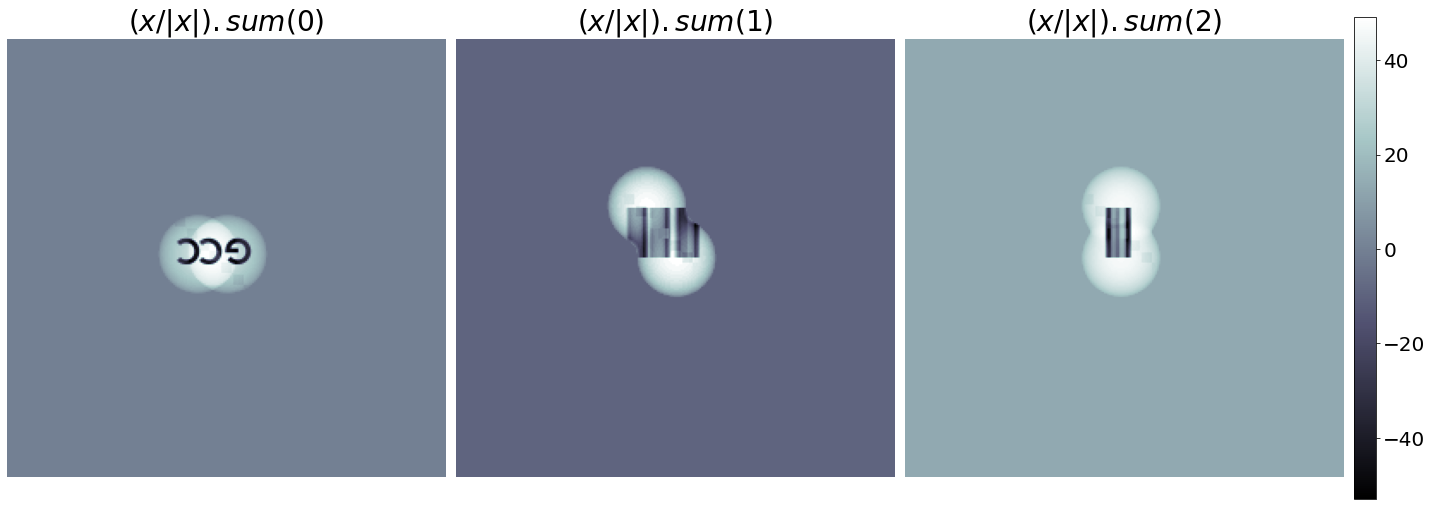

In [82]:
# Assuming out_ampli and N are defined
unpad = 0 # int(N // 4)

# Create a gridspec with 4 columns, the last column being for the color bar
fig = plt.figure(figsize=(20, 7))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05])  # Adjust width_ratios as needed

# Create the subplots
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
cax = plt.subplot(gs[3])

#out_phase =  np.fromfile(dic['output']+'.phase', dtype=np.float32).reshape([M,M,M])  
out_phase = np.angle(out_obj)
out_phase[out_phase == -np.pi] = 0
out_phase[out_phase == np.pi] = 0
out_phase = out_phase #+0.125
#out_phase = out_phase*finsup

# Plot the images
im0 = ax0.imshow(out_phase[unpad:M-unpad, unpad:M-unpad, unpad:M-unpad].sum(0), cmap='bone')
ax0.axis('off')
ax0.set_title(r"$(x/|x|).sum(0)$",fontsize = 28)
im1 = ax1.imshow(out_phase[unpad:M-unpad, unpad:M-unpad, unpad:M-unpad].sum(1), cmap='bone')
ax1.axis('off')
ax1.set_title(r"$(x/|x|).sum(1)$",fontsize = 28)
im2 = ax2.imshow(out_phase[unpad:M-unpad, unpad:M-unpad, unpad:M-unpad].sum(2), cmap='bone')
ax2.axis('off')
ax2.set_title(r"$(x/|x|).sum(2)$",fontsize = 28)

# Create the color bar in the dedicated space
cbar = fig.colorbar(im0, cax=cax)
cbar.ax.tick_params(labelsize=20)  # Adjust the fontsize as needed
# 
# plt.savefig('peanuts/peanut_recon_phase_1024.png', dpi=300, bbox_inches='tight')  # Adjust filename and parameters as needed

plt.tight_layout()
plt.show()

#### Recovered Support

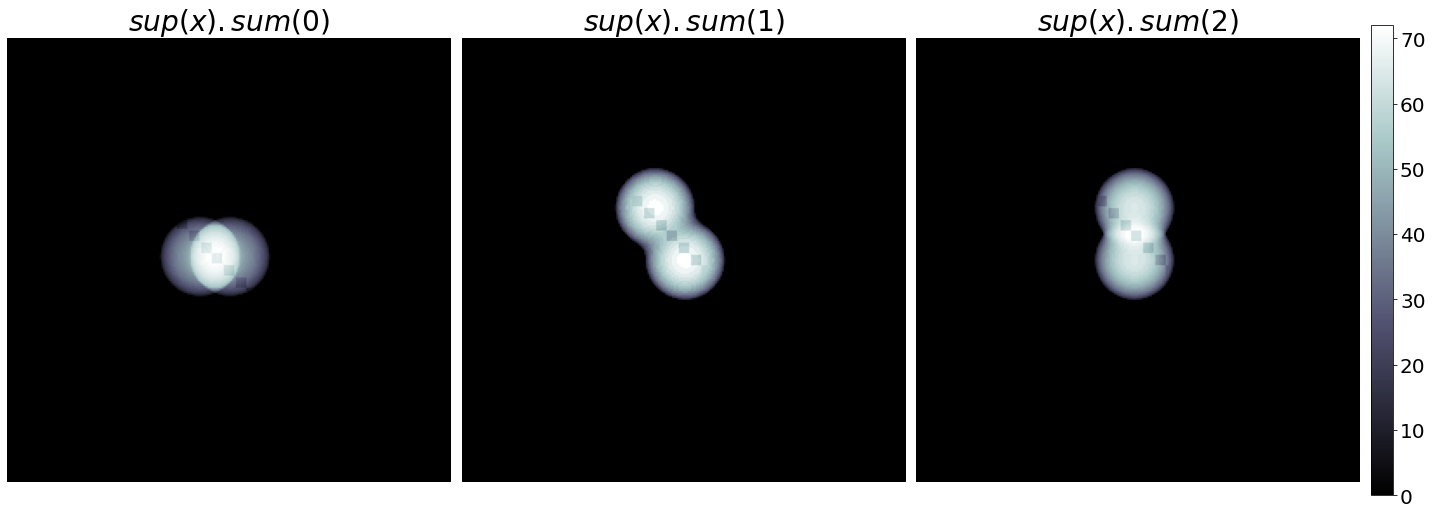

In [83]:
# Assuming out_ampli and N are defined
unpad = 0 # int(N // 4)

out_finsup = out_finsup.astype(int)
 
# Create a gridspec with 4 columns, the last column being for the color bar
fig = plt.figure(figsize=(20, 7))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05])  # Adjust width_ratios as needed

# Create the subplots
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
cax = plt.subplot(gs[3])

# Plot the images
im0 = ax0.imshow(out_finsup[unpad:M-unpad, unpad:M-unpad, unpad:M-unpad].sum(0), cmap='bone')
ax0.axis('off')
ax0.set_title(r"$sup(x).sum(0)$",fontsize = 28)
im1 = ax1.imshow(out_finsup[unpad:M-unpad, unpad:M-unpad, unpad:M-unpad].sum(1), cmap='bone')
ax1.axis('off')
ax1.set_title(r"$sup(x).sum(1)$",fontsize = 28)
im2 = ax2.imshow(out_finsup[unpad:M-unpad, unpad:M-unpad, unpad:M-unpad].sum(2), cmap='bone')
ax2.axis('off')
ax2.set_title(r"$sup(x).sum(2)$",fontsize = 28)

# Create the color bar in the dedicated space
cbar = fig.colorbar(im0, cax=cax)
cbar.ax.tick_params(labelsize=20)  # Adjust the fontsize as needed

# plt.savefig('peanuts/peanut_recon_ampli_1024.png', dpi=300, bbox_inches='tight')  # Adjust filename and parameters as needed

plt.tight_layout()
plt.show()